# Interactions

In [1]:
import warnings
warnings.filterwarnings("ignore")

In [2]:
import theano
import numpy as np
import pymc3 as pm
import pandas as pd
import seaborn as sns
import scipy.stats as stats
import matplotlib.pyplot as plt
import statsmodels.formula.api as smf
%matplotlib inline

In [3]:
sns.set()

## Building an Interaction

### 7.1

In [4]:
d = pd.read_csv('Data/rugged.csv', sep=';')

# make log version of outcome
d["log_gdp"] = np.log(d["rgdppc_2000"])

# extract countries with GDP data
dd = d[np.isfinite(d["rgdppc_2000"])]

# split countries into Africa and not-Africa
d_A1 = dd[dd["cont_africa"] == 1]
d_A0 = dd[dd["cont_africa"] == 0]

### 7.2

In [5]:
# African Nations
with pm.Model() as m7_1:
    sigma = pm.Uniform("sigma", 0, 10)
    bR = pm.Normal("bR", mu=0, sd=1)
    a = pm.Normal("a", mu=8, sd=100)
    mu = pm.Deterministic("mu", a + bR*d_A1["rugged"])
    log_gdp = pm.Normal("log_gdp", mu=mu, sd=sigma, observed=d_A1["log_gdp"])
    trace7_1 = pm.sample(draws=1000, tune=1000)
    
# non-African Nations
with pm.Model() as m7_2:
    sigma = pm.Uniform("sigma", 0, 10)
    bR = pm.Normal("bR", mu=0, sd=1)
    a = pm.Normal("a", mu=8, sd=100)
    mu = pm.Deterministic("mu", a + bR*d_A0["rugged"])
    log_gdp = pm.Normal("log_gdp", mu=mu, sd=sigma, observed=d_A0["log_gdp"])
    trace7_2 = pm.sample(draws=1000, tune=1000)

Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (2 chains in 2 jobs)
NUTS: [a, bR, sigma]
Sampling 2 chains: 100%|██████████| 4000/4000 [00:02<00:00, 1405.39draws/s]
Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (2 chains in 2 jobs)
NUTS: [a, bR, sigma]
Sampling 2 chains: 100%|██████████| 4000/4000 [00:03<00:00, 1319.76draws/s]


### 7.3

In [6]:
model_rugged = theano.shared(dd["rugged"].values)
model_cont_africa = theano.shared(dd["cont_africa"].values)

In [7]:
with pm.Model() as m7_3:
    sigma = pm.Uniform("sigma", 0, 10)
    bR = pm.Normal("bR", mu=0, sd=1)
    a = pm.Normal("a", mu=8, sd=100)
    mu = pm.Deterministic("mu", a + bR*model_rugged)
    log_gdp = pm.Normal("log_gdp", mu=mu, sd=sigma, observed=dd["log_gdp"])
    trace7_3 = pm.sample(draws=1000, tune=1000)

Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (2 chains in 2 jobs)
NUTS: [a, bR, sigma]
Sampling 2 chains: 100%|██████████| 4000/4000 [00:03<00:00, 1245.72draws/s]


### 7.4

In [8]:
with pm.Model() as m7_4:
    sigma = pm.Uniform("sigma", 0, 10)
    bR = pm.Normal("bR", mu=0, sd=1)
    bA = pm.Normal("bA", mu=0, sd=1)
    a = pm.Normal("a", mu=8, sd=100)
    mu = pm.Deterministic("mu", a + bR*model_rugged + bA*model_cont_africa)
    log_gdp = pm.Normal("log_gdp", mu=mu, sd=sigma, observed=dd["log_gdp"])
    trace7_4 = pm.sample(draws=1000, tune=1000)

Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (2 chains in 2 jobs)
NUTS: [a, bA, bR, sigma]
Sampling 2 chains: 100%|██████████| 4000/4000 [00:03<00:00, 1122.94draws/s]


### 7.5

In [9]:
(pm.compare({m7_3: trace7_3,
             m7_4: trace7_4},
            method='pseudo-BMA')
            .join(pd.Series(["m7_3", "m7_4"], name="model"))
            .set_index("model")
            .sort_values("WAIC"))

/Users/sgodiwala/anaconda3/lib/python3.6/site-packages/pymc3/stats.py:211: UserWarning: For one or more samples the posterior variance of the
        log predictive densities exceeds 0.4. This could be indication of
        WAIC starting to fail see http://arxiv.org/abs/1507.04544 for details
        
  """)


,WAIC,pWAIC,dWAIC,weight,SE,dSE,var_warn
model,,,,,,,
m7_4,476.23,4.23,0,1,14.8,0,1
m7_3,539.58,2.64,63.35,0,12.88,14.59,0


### 7.6

In [10]:
rugged_seq = np.arange(-8, 8, 0.25)
model_rugged.set_value(rugged_seq)

# compute mu over samples, fixing cont_africa=0
model_cont_africa.set_value(np.repeat(0, len(rugged_seq)))
mu_NotAfrica = pm.sample_ppc(trace7_4, samples=10000, model=m7_4, vars=[m7_4.mu])["mu"]

# compute mu over samples, fixing cont_africa=1
model_cont_africa.set_value(np.repeat(1, len(rugged_seq)))
mu_Africa = pm.sample_ppc(trace7_4, samples=10000, model=m7_4, vars=[m7_4.mu])["mu"]


mu_NotAfrica_mean = mu_NotAfrica.mean(0)
mu_NotAfrica_pi = pm.hpd(mu_NotAfrica, alpha=0.03)
mu_Africa_mean = mu_Africa.mean(0)
mu_Africa_pi = pm.hpd(mu_Africa, alpha=0.03)

100%|██████████| 10000/10000 [00:01<00:00, 8637.67it/s]


### 7.7

In [11]:
model_rugged.set_value(dd["rugged"].values)
model_cont_africa.set_value(dd["cont_africa"].values)

In [12]:
with pm.Model() as m7_5:
    sigma = pm.Uniform("sigma", 0, 10)
    bAR = pm.Normal("bAR", mu=0, sd=1)
    bR = pm.Normal("bR", mu=0, sd=1)
    bA = pm.Normal("bA", mu=0, sd=1)
    a = pm.Normal("a", mu=8, sd=100)
    gamma = pm.Deterministic("gamma", bR + bAR*model_cont_africa)
    mu = pm.Deterministic("mu", a + gamma*model_rugged + bA*model_cont_africa)
    log_gdp = pm.Normal("log_gdp", mu=mu, sd=sigma, observed=dd["log_gdp"])
    trace7_5 = pm.sample(draws=1000, tune=1000)

Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (2 chains in 2 jobs)
NUTS: [a, bA, bR, bAR, sigma]
Sampling 2 chains: 100%|██████████| 4000/4000 [00:04<00:00, 890.25draws/s] 


### 7.8

In [13]:
(pm.compare({m7_3: trace7_3,
             m7_4: trace7_4,
             m7_5: trace7_5},
            method='pseudo-BMA')
            .join(pd.Series(["m7_3", "m7_4", "m7_5"], name="model"))
            .set_index("model")
            .sort_values("WAIC"))

/Users/sgodiwala/anaconda3/lib/python3.6/site-packages/pymc3/stats.py:211: UserWarning: For one or more samples the posterior variance of the
        log predictive densities exceeds 0.4. This could be indication of
        WAIC starting to fail see http://arxiv.org/abs/1507.04544 for details
        
  """)
/Users/sgodiwala/anaconda3/lib/python3.6/site-packages/pymc3/stats.py:211: UserWarning: For one or more samples the posterior variance of the
        log predictive densities exceeds 0.4. This could be indication of
        WAIC starting to fail see http://arxiv.org/abs/1507.04544 for details
        
  """)


,WAIC,pWAIC,dWAIC,weight,SE,dSE,var_warn
model,,,,,,,
m7_5,469.1,4.91,0,0.97,14.57,0,1
m7_4,476.23,4.23,7.13,0.03,14.8,6.04,1
m7_3,539.58,2.64,70.48,0,12.88,14.65,0


### 7.9

In [14]:
with pm.Model() as m7_5b:
    sigma = pm.Uniform("sigma", 0, 10)
    bAR = pm.Normal("bAR", mu=0, sd=1)
    bR = pm.Normal("bR", mu=0, sd=1)
    bA = pm.Normal("bA", mu=0, sd=1)
    a = pm.Normal("a", mu=8, sd=100)
    mu = pm.Deterministic("mu", a +\
                                bA*dd["cont_africa"] +\
                                bR*dd["rugged"] +\
                                bAR*dd["rugged"]*dd["cont_africa"])
    log_gdp = pm.Normal("log_gdp", mu=mu, sd=sigma, observed=dd["log_gdp"])
    trace7_5b = pm.sample(draws=1000, tune=1000)

Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (2 chains in 2 jobs)
NUTS: [a, bA, bR, bAR, sigma]
Sampling 2 chains: 100%|██████████| 4000/4000 [00:04<00:00, 961.42draws/s] 


### 7.10

In [15]:
rugged_seq = np.arange(-1, 8, 0.25)
model_rugged.set_value(rugged_seq)

model_cont_africa.set_value(np.repeat(1, len(rugged_seq)))
mu_Africa = pm.sample_ppc(trace7_5, samples=10000, model=m7_5, vars=[m7_5.mu])["mu"]
mu_Africa_mean = mu_Africa.mean(0)
mu_Africa_pi = pm.hpd(mu_Africa, alpha=0.03)

model_cont_africa.set_value(np.repeat(0, len(rugged_seq)))
mu_NotAfrica = pm.sample_ppc(trace7_5, samples=10000, model=m7_5, vars=[m7_5.mu])["mu"]
mu_NotAfrica_mean = mu_NotAfrica.mean(0)
mu_NotAfrica_pi = pm.hpd(mu_NotAfrica, alpha=0.03)

100%|██████████| 10000/10000 [00:01<00:00, 7048.61it/s]


### 7.11

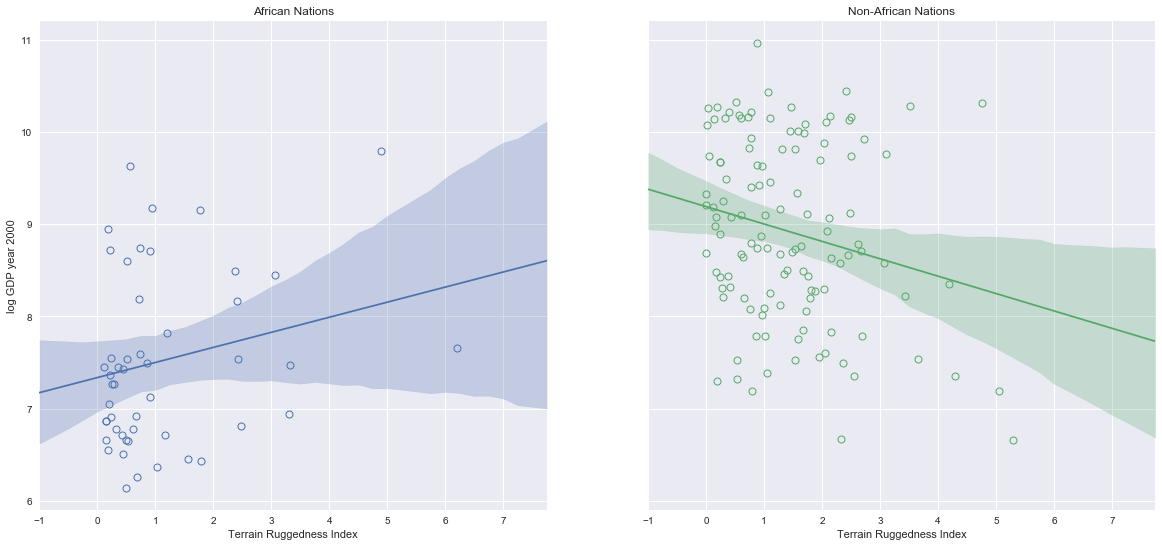

In [16]:
f, axs = plt.subplots(1, 2, sharey=True)
f.set_size_inches(20, 9)

d_A1 = dd[dd["cont_africa"] == 1]
axs[0].plot(d_A1["rugged"], d_A1["log_gdp"], "o", mew=1, mec="C0", mfc="None")
axs[0].plot(rugged_seq, mu_Africa_mean, color="C0")
axs[0].fill_between(rugged_seq, mu_Africa_pi[:,0], mu_Africa_pi[:,1], alpha=0.25, color="C0")
axs[0].set_title("African Nations")
axs[0].set_xlabel("Terrain Ruggedness Index")

d_A0 = dd[dd["cont_africa"] == 0]
axs[1].plot(d_A0["rugged"], d_A0["log_gdp"], "o", mew=1, mec="C1", mfc="None")
axs[1].plot(rugged_seq, mu_NotAfrica_mean, color="C1")
axs[1].fill_between(rugged_seq, mu_NotAfrica_pi[:,0], mu_NotAfrica_pi[:,1], alpha=0.25, color="C1")
axs[1].set_title("Non-African Nations")
axs[1].set_xlabel("Terrain Ruggedness Index")

axs[0].set_xlim((-1, 7.75))
axs[1].set_xlim((-1, 7.75))
axs[0].set_ylabel("log GDP year 2000");

### 7.12

In [17]:
pm.summary(trace7_5, varnames=["a", "bA", "bR", "bAR", "sigma"])

,mean,sd,mc_error,hpd_2.5,hpd_97.5,n_eff,Rhat
a,9.186610,0.133555,0.004548,8.903370,9.424508,859.585194,0.999534
bA,-1.852107,0.216701,0.007424,-2.276705,-1.439829,941.099068,0.999661
bR,-0.187521,0.074731,0.002555,-0.335186,-0.047336,876.368629,0.999541
bAR,0.352445,0.129111,0.004225,0.102915,0.599812,1008.491759,1.000155
sigma,0.950149,0.053791,0.001130,0.843746,1.052386,1998.482512,1.000104


### 7.13

In [18]:
gamma_Africa = trace7_5["bR"] + trace7_5["bAR"]*1
gamma_notAfrica = trace7_5["bR"] + trace7_5["bAR"]*0

### 7.14

In [19]:
(gamma_Africa.mean(),
 gamma_notAfrica.mean())

(0.16492385442405744, -0.18752083159993857)

### 7.15

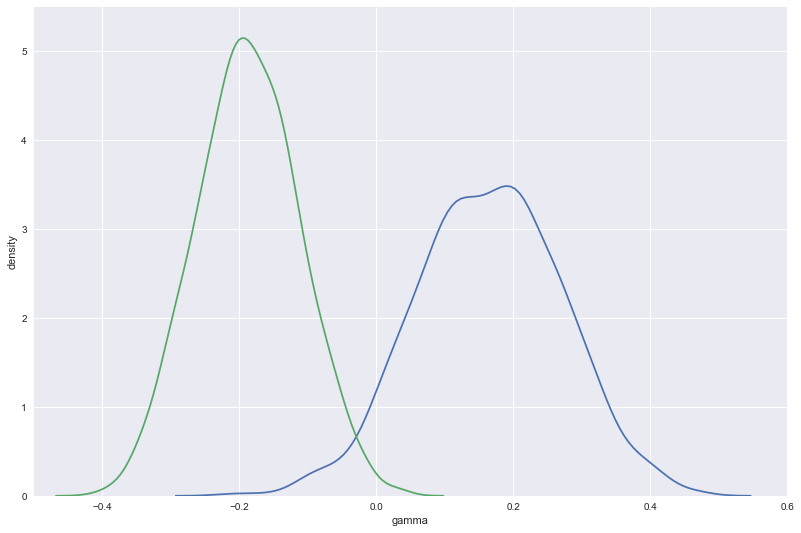

In [20]:
f, ax = plt.subplots(1, 1)
f.set_size_inches(13.5, 9)
sns.kdeplot(gamma_Africa, ax=ax)
sns.kdeplot(gamma_notAfrica, ax=ax)
ax.set_xlim((-0.5, 0.6))
ax.set_ylim((0, 5.5))
ax.set_xlabel("gamma")
ax.set_ylabel("density");

### 7.16

In [21]:
diff = gamma_Africa - gamma_notAfrica
sum(diff < 0)/len(diff)

0.005

## Symmetry of the Linear Interaction

### 7.17

100%|██████████| 10000/10000 [00:01<00:00, 6961.30it/s]


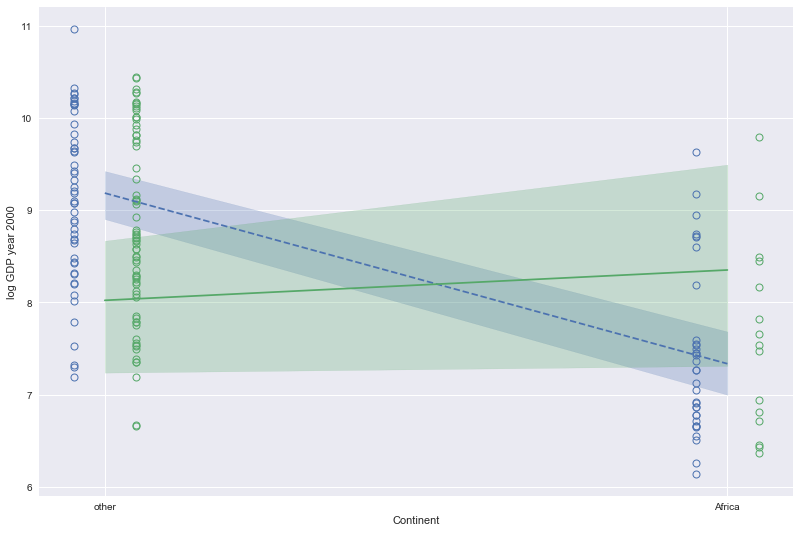

In [22]:
# get minimum and maximum rugged values
q_rugged = (dd["rugged"].min(), dd["rugged"].max())

# compute lines and confidence intervals
model_rugged.set_value(np.repeat(q_rugged[0], 2))
model_cont_africa.set_value([0, 1])
mu_ruggedlo = pm.sample_ppc(trace7_5, samples=10000, model=m7_5, vars=[m7_5.mu])["mu"]
mu_ruggedlo_mean = mu_ruggedlo.mean(0)
mu_ruggedlo_pi = pm.hpd(mu_ruggedlo)

model_rugged.set_value(np.repeat(q_rugged[1], 2))
model_cont_africa.set_value([0, 1])
mu_ruggedhi = pm.sample_ppc(trace7_5, samples=10000, model=m7_5, vars=[m7_5.mu])["mu"]
mu_ruggedhi_mean = mu_ruggedhi.mean(0)
mu_ruggedhi_pi = pm.hpd(mu_ruggedhi)

# plot it all, splitting points at median
data = (dd
        .assign(more_rugged=lambda df: df["rugged"] > np.median(df["rugged"]))
        .set_index(["more_rugged"]))

f, ax = plt.subplots(1, 1)
f.set_size_inches(13.5, 9)
ax.plot(data.loc[False]["cont_africa"] - 0.05, data.loc[False]["log_gdp"], "o", mew=1, mec="C0", mfc="None")
ax.plot(data.loc[True]["cont_africa"] + 0.05, data.loc[True]["log_gdp"], "o", mew=1, mec="C1", mfc="None")

ax.plot([0, 1], mu_ruggedlo_mean, "--", color="C0")
ax.fill_between([0, 1], mu_ruggedlo_pi[:,0], mu_ruggedlo_pi[:,1], alpha=0.25, color="C0")

ax.plot([0, 1], mu_ruggedhi_mean, color="C1")
ax.fill_between([0, 1], mu_ruggedhi_pi[:,0], mu_ruggedhi_pi[:,1], alpha=0.25, color="C1")

ax.set_xlabel("Continent")
ax.set_ylabel("log GDP year 2000")
ax.set_xticks([0, 1])
ax.set_xticklabels(["other", "Africa"]);

## Continuous Interactions

### 7.18

In [23]:
d = pd.read_csv('Data/tulips.csv', sep=';')
d.head()

,bed,water,shade,blooms
0,a,1,1,0.00
1,a,1,2,0.00
2,a,1,3,111.04
3,a,2,1,183.47
4,a,2,2,59.16


### 7.19

In [24]:
with pm.Model() as m7_6:
    sigma = pm.Uniform("sigma", 0, 100)
    bS = pm.Normal("bS", mu=0, sd=100)
    bW = pm.Normal("bW", mu=0, sd=100)
    a = pm.Normal("a", mu=0, sd=100)
    mu = pm.Deterministic("mu", a +\
                                bW*d["water"] +\
                                bS*d["shade"])
    blooms = pm.Normal("blooms", mu=mu, sd=sigma, observed=d["blooms"])
    trace7_6 = pm.sample(draws=1000, tune=1000)
    
with pm.Model() as m7_7:
    sigma = pm.Uniform("sigma", 0, 100)
    bWS = pm.Normal("bWS", mu=0, sd=100) 
    bS = pm.Normal("bS", mu=0, sd=100)
    bW = pm.Normal("bW", mu=0, sd=100)
    a = pm.Normal("a", mu=0, sd=100)
    mu = pm.Deterministic("mu", a +\
                                bW*d["water"] +\
                                bS*d["shade"] +\
                                bWS*d["water"]*d["shade"])
    blooms = pm.Normal("blooms", mu=mu, sd=sigma, observed=d["blooms"])
    trace7_7 = pm.sample(draws=1000, tune=1000)

Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (2 chains in 2 jobs)
NUTS: [a, bW, bS, sigma]
Sampling 2 chains: 100%|██████████| 4000/4000 [00:05<00:00, 741.69draws/s]
The acceptance probability does not match the target. It is 0.8796835256718785, but should be close to 0.8. Try to increase the number of tuning steps.
Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (2 chains in 2 jobs)
NUTS: [a, bW, bS, bWS, sigma]
Sampling 2 chains: 100%|██████████| 4000/4000 [00:14<00:00, 279.51draws/s]
There was 1 divergence after tuning. Increase `target_accept` or reparameterize.
There were 5 divergences after tuning. Increase `target_accept` or reparameterize.
The acceptance probability does not match the target. It is 0.6976874984921038, but should be close to 0.8. Try to increase the number of tuning steps.
The number of effective samples is smaller than 25% for some parameters.


### 7.20

Since I'm not using MAP but MCMC, I'm not implementing the MAP optimisation

### 7.21

In [25]:
(pm.summary(trace7_6, varnames=["a", "bW", "bS", "sigma"])[["mean"]]
 .join(pm.summary(trace7_7, varnames=["a", "bW", "bS", "sigma", "bWS"])[["mean"]],
       lsuffix="_7_6", rsuffix="_7_7", how="outer"))

,mean_7_6,mean_7_7
a,53.038154,-73.762014
bS,-38.467203,30.016176
bW,75.988809,145.862007
bWS,NaN,-37.052386
sigma,64.139400,52.719196


### 7.22

In [26]:
(pm.compare({m7_6: trace7_6,
             m7_7: trace7_7},
            method='pseudo-BMA')
            .join(pd.Series(["m7_6", "m7_7"], name="model"))
            .set_index("model")
            .sort_values("WAIC"))

/Users/sgodiwala/anaconda3/lib/python3.6/site-packages/pymc3/stats.py:211: UserWarning: For one or more samples the posterior variance of the
        log predictive densities exceeds 0.4. This could be indication of
        WAIC starting to fail see http://arxiv.org/abs/1507.04544 for details
        
  """)
/Users/sgodiwala/anaconda3/lib/python3.6/site-packages/pymc3/stats.py:211: UserWarning: For one or more samples the posterior variance of the
        log predictive densities exceeds 0.4. This could be indication of
        WAIC starting to fail see http://arxiv.org/abs/1507.04544 for details
        
  """)


,WAIC,pWAIC,dWAIC,weight,SE,dSE,var_warn
model,,,,,,,
m7_7,294.63,4.43,0,0.99,7.39,0,1
m7_6,303.52,3.52,8.89,0.01,6.77,4.13,1


### 7.23

In [27]:
d["shade_c"] = d["shade"] - d["shade"].mean()
d["water_c"] = d["water"] - d["water"].mean()

### 7.24

There isn't a way to set starting parameters that I can find, you could encode them in the priors though.

In [28]:
model_water_c = theano.shared(d["water_c"].values)
model_shade_c = theano.shared(d["shade_c"].values)

In [29]:
with pm.Model() as m7_8:
    sigma = pm.Uniform("sigma", 0, 100)
    bS = pm.Normal("bS", mu=0, sd=100)
    bW = pm.Normal("bW", mu=0, sd=100)
    a = pm.Normal("a", mu=130, sd=100)
    mu = pm.Deterministic("mu", a +\
                                bW*model_water_c +\
                                bS*model_shade_c)
    blooms = pm.Normal("blooms", mu=mu, sd=sigma, observed=d["blooms"])
    trace7_8 = pm.sample(draws=1000, tune=1000)
    
with pm.Model() as m7_9:
    sigma = pm.Uniform("sigma", 0, 100)
    bWS = pm.Normal("bWS", mu=0, sd=100) 
    bS = pm.Normal("bS", mu=0, sd=100)
    bW = pm.Normal("bW", mu=0, sd=100)
    a = pm.Normal("a", mu=0, sd=100)
    mu = pm.Deterministic("mu", a +\
                                bW*model_water_c +\
                                bS*model_shade_c +\
                                bWS*model_water_c*model_shade_c)
    blooms = pm.Normal("blooms", mu=mu, sd=sigma, observed=d["blooms"])
    trace7_9 = pm.sample(draws=1000, tune=1000)
    
(pm.summary(trace7_8, varnames=["a", "bW", "bS", "sigma"])[["mean"]]
 .join(pm.summary(trace7_9, varnames=["a", "bW", "bS", "sigma", "bWS"])[["mean"]],
       lsuffix="_7_8", rsuffix="_7_9", how="outer"))

Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (2 chains in 2 jobs)
NUTS: [a, bW, bS, sigma]
Sampling 2 chains: 100%|██████████| 4000/4000 [00:04<00:00, 846.87draws/s] 
There were 6 divergences after tuning. Increase `target_accept` or reparameterize.
The acceptance probability does not match the target. It is 0.6342886749135742, but should be close to 0.8. Try to increase the number of tuning steps.
Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (2 chains in 2 jobs)
NUTS: [a, bW, bS, bWS, sigma]
Sampling 2 chains: 100%|██████████| 4000/4000 [00:04<00:00, 802.69draws/s] 


,mean_7_8,mean_7_9
a,129.064886,127.719214
bS,-40.617730,-40.988078
bW,74.499905,74.758070
bWS,NaN,-51.197238
sigma,64.307348,52.059869


### 7.25

In [30]:
k = pm.summary(trace7_7, varnames=["a", "bW", "bS", "bWS"])["mean"]
k["a"] + k["bW"]*2 + k["bS"]*2 + k["bWS"]*2*2

129.78480871159033

### 7.26

In [31]:
k = pm.summary(trace7_9, varnames=["a", "bW", "bS", "bWS"])["mean"]
k["a"] + k["bW"]*0 + k["bS"]*0 + k["bWS"]*0*0

127.7192144478923

### 7.27

In [32]:
(pm.summary(trace7_9, varnames=["a", "bW", "bS", "bWS", "sigma"], alpha=0.11)
 .round(2)
 [["mean", "sd", "hpd_5.5", "hpd_94.5"]])

,mean,sd,hpd_5.5,hpd_94.5
a,127.72,10.03,110.31,142.20
bW,74.76,12.39,56.04,94.32
bS,-40.99,12.26,-60.18,-21.22
bWS,-51.20,15.76,-77.78,-27.67
sigma,52.06,8.97,38.09,63.88


### 7.28

100%|██████████| 10000/10000 [00:01<00:00, 6660.44it/s]


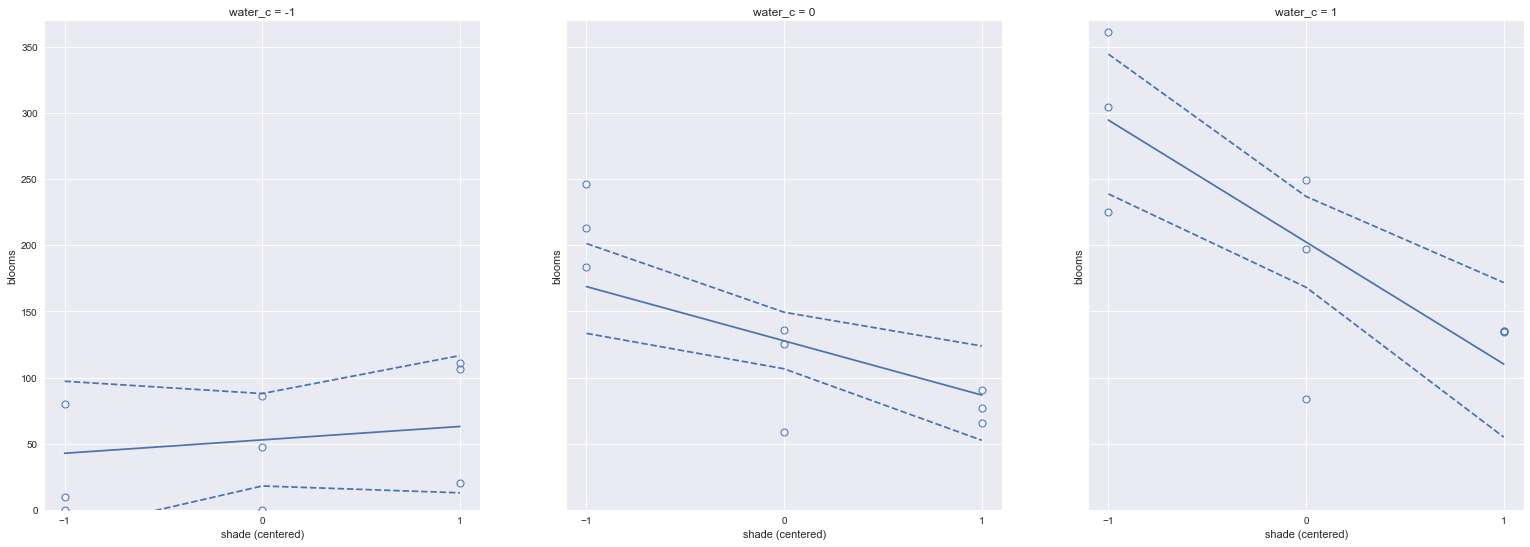

In [33]:
f, axs = plt.subplots(1, 3, sharey=True)
f.set_size_inches(26.5, 9)

shade_seq = np.arange(-1, 2)
model_shade_c.set_value(shade_seq)

for w, ax in zip(range(-1, 2), axs):
    dt = d[d["water_c"] == w]
    ax.plot(dt["shade_c"], dt["blooms"], "o", mew=1, mec="C0", mfc="None")
    ax.set_xticks(shade_seq)
    ax.set_ylim(0, 370)
    ax.set_title("water_c = {}".format(w))
    ax.set_xlabel("shade (centered)")
    ax.set_ylabel("blooms")
    model_water_c.set_value(np.repeat(w, len(shade_seq)))
    mu = pm.sample_ppc(trace7_9, samples=10000, model=m7_9, vars=[m7_9.mu])["mu"]
    mu_mean = mu.mean(0)
    mu_pi = pm.hpd(mu, alpha=0.03)
    ax.plot(shade_seq, mu_mean, color="C0")
    ax.plot(shade_seq, mu_pi[:, 0], "--", color="C0")
    ax.plot(shade_seq, mu_pi[:, 1], "--", color="C0")

## Interactions in Design Formulas

### 7.29

In [34]:
m7_x = smf.ols("blooms ~ shade + water + shade * water", data=d).fit()

### 7.30

In [35]:
m7_x = smf.ols("blooms ~ shade * water", data=d).fit()

### 7.31

In [36]:
m7_x = smf.ols("blooms ~ shade * water - water", data=d).fit()

### 7.32

In [37]:
m7_x = smf.ols('blooms ~ shade * water * bed', data=d).fit()

### 7.33

In [38]:
y = pd.DataFrame({"y": [1], "x": [1], "z": [1], "w": [1]})

In [39]:
(smf.ols('y ~ x * z * w', data=y)
 .fit()
 .params
 .index)

Index(['Intercept', 'x', 'z', 'x:z', 'w', 'x:w', 'z:w', 'x:z:w'], dtype='object')

## Practice

### Easy

#### 7E1.

1.
Bread rises because of the amount of yeast and the amount of sugar, there's an interaction effect between sugar and yeast.

2.
Income rises because of _education_, or the certification of a skill, and _demand_, the need for the skill, there's an interaction effect between education and demand.

3.
A car goes because of an engine and the presence of gasoline, there's an interaction effect between the presence of an engine and the presence of gasoline

#### 7E2.

1.
An interaction is needed since there's an _and_ in the explanation

2.
An interaction is not needed since there's an <i>or</i> in the explanation

3.
An interaction is needed since there is a condition in the explanation

4.
An interaction is not needed since there's an <i>or</i> in the explanation

#### 7E3.

1. 
is_caramelised ~ is_low_heat * is_dried_out

2. 
speed ~ num_cylinders + injector_quality

3. 
belief ~ friend_belief * family_belief

4. 
is_intelligent ~ is_social + has_appendage

#### 7M1.

Whenever the temperature is hot, the values of shade and water shouldn't have any effect on the number of blooms produced, or should neutralise the effect of any of the other features.

#### 7M2.

blooms ~ water x temperature + shade x temperature + water x shade x temperature

Where temperature 0s out the values when hot

#### 7M3.

In [40]:
pd.DataFrame([[0, 0, False, False],
              [0, 5, False, True],
              [0, 6, False, True],
              [0, 0, True, False],
              [20, 5, True, True],
              [24, 6, True, True]],
             columns=["num_ravens", "num_wolves", "raven_climate", "wolf_climate"])

,num_ravens,num_wolves,raven_climate,wolf_climate
0,0,0,False,False
1,0,5,False,True
2,0,6,False,True
3,0,0,True,False
4,20,5,True,True
5,24,6,True,True


The relationship between `num_ravens` and the features here is non linear since the number of ravens is 0 when `wolf_climate` is false, whatever the value of `raven_climate`

#### 7H1.

In [41]:
tulips = pd.read_csv('Data/tulips.csv', sep=';')
tulips["shade_c"] = tulips["shade"] - tulips["shade"].mean()
tulips["water_c"] = tulips["water"] - tulips["water"].mean()
tulips["is_bed_b"] = np.where(tulips["bed"] == "b", 1, 0)
tulips["is_bed_c"] = np.where(tulips["bed"] == "c", 1, 0)
tulips.head()

,bed,water,shade,blooms,shade_c,water_c,is_bed_b,is_bed_c
0,a,1,1,0.00,-1.0,-1.0,0,0
1,a,1,2,0.00,0.0,-1.0,0,0
2,a,1,3,111.04,1.0,-1.0,0,0
3,a,2,1,183.47,-1.0,0.0,0,0
4,a,2,2,59.16,0.0,0.0,0,0


In [42]:
with pm.Model() as m7h_1:
    sigma = pm.Uniform("sigma", 0, 100)
    bWS = pm.Normal("bWS", mu=0, sd=100) 
    bS = pm.Normal("bS", mu=0, sd=100)
    bW = pm.Normal("bW", mu=0, sd=100)
    bBb = pm.Normal("bBb", mu=0, sd=100)
    bBc = pm.Normal("bBc", mu=0, sd=100)
    a = pm.Normal("a", mu=0, sd=100)
    mu = pm.Deterministic("mu", a +\
                                bW*tulips["water_c"] +\
                                bS*tulips["shade_c"] +\
                                bWS*tulips["water_c"]*tulips["shade_c"] +\
                                bBb*tulips["is_bed_b"] +\
                                bBc*tulips["is_bed_c"])
    blooms = pm.Normal("blooms", mu=mu, sd=sigma, observed=d["blooms"])
    trace7h_1 = pm.sample(draws=1000, tune=1000)
    
pm.summary(trace7h_1, varnames=["a", "bWS", "bS", "bW", "bBb", "bBc"], alpha=0.11)

Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (2 chains in 2 jobs)
NUTS: [a, bBc, bBb, bW, bS, bWS, sigma]
Sampling 2 chains: 100%|██████████| 4000/4000 [00:06<00:00, 627.32draws/s]


,mean,sd,mc_error,hpd_5.5,hpd_94.5,n_eff,Rhat
a,96.708445,14.920410,0.409546,75.028480,121.777194,1311.427954,0.999538
bWS,-51.665986,13.712597,0.277192,-74.051255,-30.605032,2433.097218,1.001044
bS,-41.064654,11.134061,0.230405,-58.924632,-23.731294,2163.211132,0.999510
bW,74.725858,11.073362,0.206912,56.448859,91.579348,2170.429330,0.999707
bBb,44.763495,20.654619,0.539618,13.073246,77.216407,1465.365515,0.999503
bBc,49.290426,21.189880,0.523541,15.646894,82.744057,1507.156258,0.999563


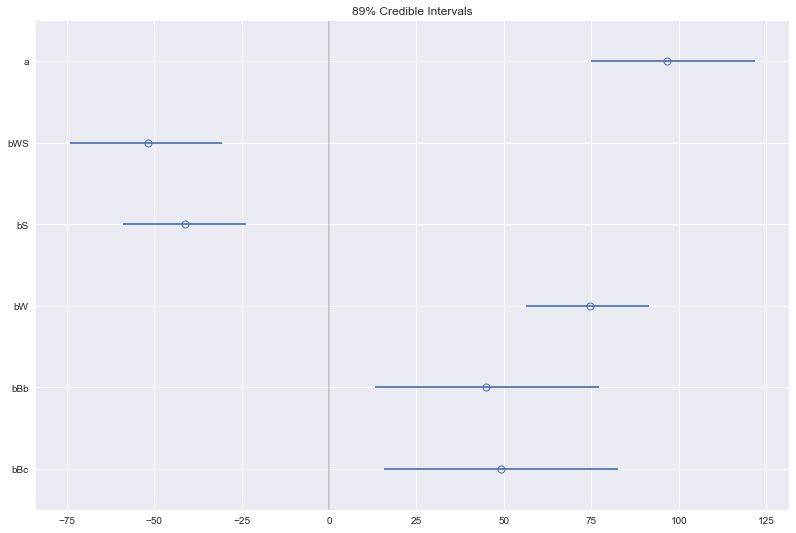

In [43]:
f, ax = plt.subplots(1, 1)
f.set_size_inches(13.5, 9)
data = (pm.summary(trace7h_1, varnames=["a", "bWS", "bS", "bW", "bBb", "bBc"], alpha=0.11)
        .assign(hpd_minus=lambda df: df["mean"] - df["hpd_5.5"])
        .assign(hpd_plus=lambda df: df["hpd_94.5"]- df["mean"]))
ax.errorbar(data["mean"], data.index, fmt="o", xerr=data[["hpd_minus", "hpd_plus"]].T.values, 
            mew=1, mfc="None")
ax.vlines(0, ymin=-1, ymax=6, alpha=0.2);
ax.set_ylim(-0.5, 5.5)
ax.invert_yaxis()
ax.set_title("89% Credible Intervals");

#### 7H2.

In [44]:
# retraining m7_9 as m7h_2 
with pm.Model() as m7h_2:
    sigma = pm.Uniform("sigma", 0, 100)
    bWS = pm.Normal("bWS", mu=0, sd=100) 
    bS = pm.Normal("bS", mu=0, sd=100)
    bW = pm.Normal("bW", mu=0, sd=100)
    a = pm.Normal("a", mu=0, sd=100)
    mu = pm.Deterministic("mu", a +\
                                bW*tulips["water_c"] +\
                                bS*tulips["shade_c"] +\
                                bWS*tulips["water_c"]*tulips["shade_c"])
    blooms = pm.Normal("blooms", mu=mu, sd=sigma, observed=d["blooms"])
    trace7h_2 = pm.sample(draws=1000, tune=1000)

Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (2 chains in 2 jobs)
NUTS: [a, bW, bS, bWS, sigma]
Sampling 2 chains: 100%|██████████| 4000/4000 [00:04<00:00, 911.13draws/s] 
The acceptance probability does not match the target. It is 0.6752516397725246, but should be close to 0.8. Try to increase the number of tuning steps.


In [45]:
(pm.compare({m7h_1: trace7h_1,
             m7h_2: trace7h_2},
            method='pseudo-BMA')
            .join(pd.Series(["m7h_1", "m7h_2"], name="model"))
            .set_index("model")
            .sort_values("WAIC"))

/Users/sgodiwala/anaconda3/lib/python3.6/site-packages/pymc3/stats.py:211: UserWarning: For one or more samples the posterior variance of the
        log predictive densities exceeds 0.4. This could be indication of
        WAIC starting to fail see http://arxiv.org/abs/1507.04544 for details
        
  """)
/Users/sgodiwala/anaconda3/lib/python3.6/site-packages/pymc3/stats.py:211: UserWarning: For one or more samples the posterior variance of the
        log predictive densities exceeds 0.4. This could be indication of
        WAIC starting to fail see http://arxiv.org/abs/1507.04544 for details
        
  """)


,WAIC,pWAIC,dWAIC,weight,SE,dSE,var_warn
model,,,,,,,
m7h_1,289.82,5.89,0,0.84,6.42,0,1
m7h_2,293.12,4.33,3.3,0.16,7.22,5.39,1


WAIC does give more weight to the model with the added `bed` feature, this also shows from the posterior distribution of coefficients where `bBb` and `bBc` had distributions that didn't overlap with 0, i.e. they were informative.

#### 7H3.

In [46]:
rugged_seych = (pd.read_csv('Data/rugged.csv', sep=';')
                .loc[lambda df: np.isfinite(df["rgdppc_2000"])]
                .assign(log_rgdppc_2000=lambda df: np.log(df["rgdppc_2000"])))

rugged_nonch = (rugged_seych
                .loc[lambda df: df["country"] != "Seychelles"])

print(len(rugged_seych))
print(len(rugged_nonch))
rugged_seych.head()

170
169


,isocode,isonum,country,rugged,rugged_popw,rugged_slope,rugged_lsd,rugged_pc,land_area,lat,...,africa_region_e,africa_region_c,slave_exports,dist_slavemkt_atlantic,dist_slavemkt_indian,dist_slavemkt_saharan,dist_slavemkt_redsea,pop_1400,european_descent,log_rgdppc_2000
2,AGO,24,Angola,0.858,0.714,2.274,0.228,4.906,124670.0,-12.299,...,0,1,3610000.0,5.669,6.981,4.926,3.872,1223208.0,2.000,7.492609
4,ALB,8,Albania,3.427,1.597,10.451,1.006,62.133,2740.0,41.143,...,0,0,0.0,NaN,NaN,NaN,NaN,200000.0,100.000,8.216929
7,ARE,784,United Arab Emirates,0.769,0.316,2.112,0.191,6.142,8360.0,23.913,...,0,0,0.0,NaN,NaN,NaN,NaN,19200.0,0.000,9.933263
8,ARG,32,Argentina,0.775,0.220,2.268,0.226,9.407,273669.0,-35.396,...,0,0,0.0,NaN,NaN,NaN,NaN,276632.0,89.889,9.407032
9,ARM,51,Armenia,2.688,0.934,8.178,0.799,50.556,2820.0,40.294,...,0,0,0.0,NaN,NaN,NaN,NaN,105743.0,0.500,7.792343


##### (a)

In [47]:
model_rugged = theano.shared(rugged_nonch["rugged"].values)
model_cont_africa = theano.shared(rugged_nonch["cont_africa"].values)

In [48]:
with pm.Model() as m7h_3:
    sigma = pm.Uniform("sigma", 0, 10)
    bA = pm.Normal("bA", mu=0, sd=1)
    bR = pm.Normal("bR", mu=0, sd=1)
    bAR = pm.Normal("bAR", mu=0, sd=1)
    a = pm.Normal("a", mu=8, sd=100)
    mu = pm.Deterministic("mu", a +\
                                bA*model_cont_africa +\
                                bR*model_rugged +\
                                bAR*model_cont_africa*model_rugged)
    log_rgdppc_2000 = pm.Normal("log_rgdppc_2000", mu=mu, sd=sigma, observed=rugged_nonch["log_rgdppc_2000"])
    trace7h_3 = pm.sample(draws=1000, tune=1000)

pm.summary(trace7h_3, varnames=["a", "bAR", "bA", "bR"], alpha=0.11)

Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (2 chains in 2 jobs)
NUTS: [a, bAR, bR, bA, sigma]
Sampling 2 chains: 100%|██████████| 4000/4000 [00:07<00:00, 567.29draws/s]


,mean,sd,mc_error,hpd_5.5,hpd_94.5,n_eff,Rhat
a,9.195706,0.139794,0.004600,8.955724,9.406961,851.660721,1.004180
bAR,0.261704,0.137576,0.004146,0.051106,0.484170,1065.820328,0.999633
bA,-1.798250,0.222453,0.006529,-2.141716,-1.450404,1092.965339,1.000458
bR,-0.190998,0.075709,0.002616,-0.305827,-0.063986,833.179833,1.000690


In [49]:
model_rugged.set_value(rugged_seych["rugged"].values)
model_cont_africa.set_value(rugged_seych["cont_africa"].values)

In [50]:
# retraining m7_5b as m7h_4 
with pm.Model() as m7h_4:
    sigma = pm.Uniform("sigma", 0, 10)
    bAR = pm.Normal("bAR", mu=0, sd=1)
    bR = pm.Normal("bR", mu=0, sd=1)
    bA = pm.Normal("bA", mu=0, sd=1)
    a = pm.Normal("a", mu=8, sd=100)
    mu = pm.Deterministic("mu", a +\
                                bA*model_cont_africa +\
                                bR*model_rugged +\
                                bAR*model_cont_africa*model_rugged)
    log_rgdppc_2000 = pm.Normal("log_rgdppc_2000", mu=mu, sd=sigma, observed=rugged_seych["log_rgdppc_2000"])
    trace7h_4 = pm.sample(draws=1000, tune=1000)
    
pm.summary(trace7h_4, varnames=["a", "bAR", "bA", "bR"], alpha=0.11)

Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (2 chains in 2 jobs)
NUTS: [a, bA, bR, bAR, sigma]
Sampling 2 chains: 100%|██████████| 4000/4000 [00:05<00:00, 776.44draws/s]


,mean,sd,mc_error,hpd_5.5,hpd_94.5,n_eff,Rhat
a,9.180432,0.135494,0.004340,8.969341,9.389103,861.999854,0.999611
bAR,0.344513,0.126285,0.004259,0.143619,0.542572,925.364201,0.999743
bA,-1.835962,0.220261,0.006859,-2.135082,-1.438568,1005.633836,1.000642
bR,-0.182912,0.076855,0.002624,-0.309737,-0.066196,767.212711,1.000238


Without Seychelles, the posterior distribution of `bAR` almost overlaps 0 (89%) and the mean of the coefficient has dropped from 0.35 to 0.25, the effect of Seychelles on Africa's resilience to ruggedness is quite large.

##### (b)

In [51]:
rugged_seq = np.arange(-1, 8, 0.25)
model_rugged.set_value(rugged_seq)

model_cont_africa.set_value(np.repeat(0, len(rugged_seq)))

mu_nans = pm.sample_ppc(trace7h_3, samples=10000, model=m7h_3, vars=[m7h_3.mu])["mu"]
mu_nans_mean = mu_nans.mean(0)
mu_nans_pi = pm.hpd(mu_nans, alpha=0.11)

mu_naws = pm.sample_ppc(trace7h_4, samples=10000, model=m7h_4, vars=[m7h_4.mu])["mu"]
mu_naws_mean = mu_naws.mean(0)
mu_naws_pi = pm.hpd(mu_naws, alpha=0.11)

model_cont_africa.set_value(np.repeat(1, len(rugged_seq)))

mu_wans = pm.sample_ppc(trace7h_3, samples=10000, model=m7h_3, vars=[m7h_3.mu])["mu"]
mu_wans_mean = mu_wans.mean(0)
mu_wans_pi = pm.hpd(mu_wans, alpha=0.11)

mu_waws = pm.sample_ppc(trace7h_4, samples=10000, model=m7h_4, vars=[m7h_4.mu])["mu"]
mu_waws_mean = mu_waws.mean(0)
mu_waws_pi = pm.hpd(mu_waws, alpha=0.11)

100%|██████████| 10000/10000 [00:01<00:00, 6739.63it/s]


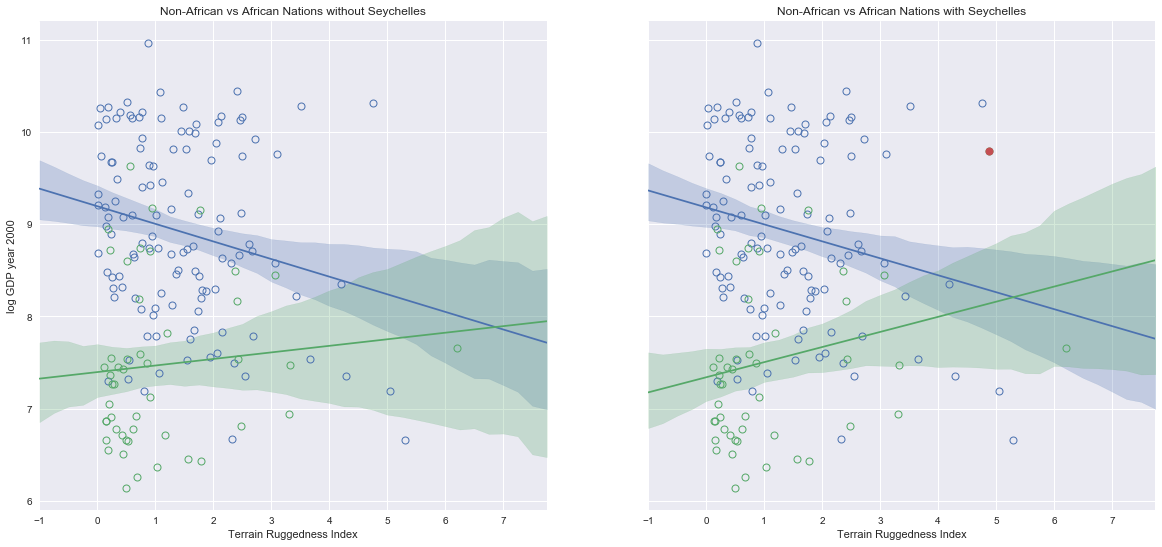

In [52]:
f, axs = plt.subplots(1, 2, sharey=True)
f.set_size_inches(20, 9)

axs[0].plot(rugged_nonch.loc[lambda df: df["cont_africa"] == 0]["rugged"], 
            rugged_nonch.loc[lambda df: df["cont_africa"] == 0]["log_rgdppc_2000"], 
            "o", mew=1, mec="C0", mfc="None")
axs[0].plot(rugged_nonch.loc[lambda df: df["cont_africa"] == 1]["rugged"], 
            rugged_nonch.loc[lambda df: df["cont_africa"] == 1]["log_rgdppc_2000"], 
            "o", mew=1, mec="C1", mfc="None")
axs[0].plot(rugged_seq, mu_nans_mean, color="C0")
axs[0].plot(rugged_seq, mu_wans_mean, color="C1")
axs[0].fill_between(rugged_seq, mu_nans_pi[:,0], mu_nans_pi[:,1], alpha=0.25, color="C0")
axs[0].fill_between(rugged_seq, mu_wans_pi[:,0], mu_wans_pi[:,1], alpha=0.25, color="C1")
axs[0].set_title("Non-African vs African Nations without Seychelles")
axs[0].set_xlabel("Terrain Ruggedness Index")

data_seych = rugged_seych.loc[lambda df: df["country"] == "Seychelles"]
axs[1].plot(rugged_seych.loc[lambda df: df["cont_africa"] == 0]["rugged"], 
            rugged_seych.loc[lambda df: df["cont_africa"] == 0]["log_rgdppc_2000"], 
            "o", mew=1, mec="C0", mfc="None")
axs[1].plot(rugged_seych.loc[lambda df: df["cont_africa"] == 1]["rugged"], 
            rugged_seych.loc[lambda df: df["cont_africa"] == 1]["log_rgdppc_2000"], 
            "o", mew=1, mec="C1", mfc="None")
axs[1].plot(data_seych["rugged"], data_seych["log_rgdppc_2000"],
            "o", mew=1, mec="C2")
axs[1].plot(rugged_seq, mu_naws_mean, color="C0")
axs[1].plot(rugged_seq, mu_waws_mean, color="C1")
axs[1].fill_between(rugged_seq, mu_naws_pi[:,0], mu_naws_pi[:,1], alpha=0.25, color="C0")
axs[1].fill_between(rugged_seq, mu_waws_pi[:,0], mu_waws_pi[:,1], alpha=0.25, color="C1")
axs[1].set_title("Non-African vs African Nations with Seychelles")
axs[1].set_xlabel("Terrain Ruggedness Index")

axs[0].set_xlim((-1, 7.75))
axs[1].set_xlim((-1, 7.75))
axs[0].set_ylabel("log GDP year 2000");

Even without Seychelles, it does look like the effect of ruggedness on GDP is mildly positive in African Nations compared to quite negative in Non African ones, while the effect is greatly diminished, it hasn't reversed to match the slope for Non-African Nations.

##### (c)

In [53]:
model_rugged = theano.shared(rugged_nonch["rugged"].values)
model_cont_africa = theano.shared(rugged_nonch["cont_africa"].values)

In [54]:
with pm.Model() as m7h_5:
    sigma = pm.Uniform("sigma", 0, 10)
    bR = pm.Normal("bR", mu=0, sd=1)
    a = pm.Normal("a", mu=8, sd=100)
    mu = pm.Deterministic("mu", a +\
                                bR*model_rugged)
    log_rgdppc_2000 = pm.Normal("log_rgdppc_2000", mu=mu, sd=sigma, observed=rugged_nonch["log_rgdppc_2000"])
    trace7h_5 = pm.sample(draws=1000, tune=1000)
    
with pm.Model() as m7h_6:
    sigma = pm.Uniform("sigma", 0, 10)
    bR = pm.Normal("bR", mu=0, sd=1)
    bA = pm.Normal("bA", mu=0, sd=1)
    a = pm.Normal("a", mu=8, sd=100)
    mu = pm.Deterministic("mu", a +\
                                bR*model_rugged +\
                                bA*model_cont_africa)
    log_rgdppc_2000 = pm.Normal("log_rgdppc_2000", mu=mu, sd=sigma, observed=rugged_nonch["log_rgdppc_2000"])
    trace7h_6 = pm.sample(draws=1000, tune=1000)
    
with pm.Model() as m7h_7:
    sigma = pm.Uniform("sigma", 0, 10)
    bR = pm.Normal("bR", mu=0, sd=1)
    bA = pm.Normal("bA", mu=0, sd=1)
    bAR = pm.Normal("bAR", mu=0, sd=1)
    a = pm.Normal("a", mu=8, sd=100)
    mu = pm.Deterministic("mu", a +\
                                bR*model_rugged +\
                                bA*model_cont_africa +\
                                bAR*model_cont_africa*model_rugged)
    log_rgdppc_2000 = pm.Normal("log_rgdppc_2000", mu=mu, sd=sigma, observed=rugged_nonch["log_rgdppc_2000"])
    trace7h_7 = pm.sample(draws=1000, tune=1000)

Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (2 chains in 2 jobs)
NUTS: [a, bR, sigma]
Sampling 2 chains: 100%|██████████| 4000/4000 [00:03<00:00, 1182.46draws/s]
Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (2 chains in 2 jobs)
NUTS: [a, bA, bR, sigma]
Sampling 2 chains: 100%|██████████| 4000/4000 [00:04<00:00, 950.21draws/s] 
Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (2 chains in 2 jobs)
NUTS: [a, bAR, bA, bR, sigma]
Sampling 2 chains: 100%|██████████| 4000/4000 [00:05<00:00, 717.87draws/s]


In [55]:
rugged_models = (pm.compare({m7h_5: trace7h_5,
                             m7h_6: trace7h_6,
                             m7h_7: trace7h_7},
                            method='pseudo-BMA')
                .join(pd.Series(["m7h_5", "m7h_6", "m7h_7"], name="model"))
                .set_index("model")
                .sort_values("WAIC"))
rugged_models

/Users/sgodiwala/anaconda3/lib/python3.6/site-packages/pymc3/stats.py:211: UserWarning: For one or more samples the posterior variance of the
        log predictive densities exceeds 0.4. This could be indication of
        WAIC starting to fail see http://arxiv.org/abs/1507.04544 for details
        
  """)


,WAIC,pWAIC,dWAIC,weight,SE,dSE,var_warn
model,,,,,,,
m7h_7,463.06,4.29,0,0.81,14.41,0,1
m7h_6,465.96,3.75,2.91,0.19,13.73,3.15,0
m7h_5,536.18,2.64,73.13,0,12.95,14.6,0


In [56]:
models = {"m7h_5": {"trace": trace7h_5,
                    "model": m7h_5,
                    "weight": rugged_models.loc["m7h_5"]["weight"]},
          "m7h_6": {"trace": trace7h_6,
                    "model": m7h_6,
                    "weight": rugged_models.loc["m7h_6"]["weight"]},
          "m7h_7": {"trace": trace7h_7,
                     "model": m7h_7,
                     "weight": rugged_models.loc["m7h_7"]["weight"]}}

In [57]:
num_samples = 10000
rugged_seq = np.arange(-1, 8, 0.25)
model_rugged.set_value(rugged_seq)

model_cont_africa.set_value(np.repeat(0, len(rugged_seq)))
acc = []
for (_, mdata) in models.items():
    pred = pm.sample_ppc(mdata["trace"], 
                         samples=int(mdata["weight"]*num_samples),
                         model=mdata["model"],
                         vars=[mdata["model"].mu])
    acc.append(pred["mu"])
wmu_na = np.vstack(acc)
wmu_na_mean = wmu_na.mean(0)
wmu_na_pi = pm.hpd(wmu_na, alpha=0.11)

model_cont_africa.set_value(np.repeat(1, len(rugged_seq)))
acc = []
for (_, mdata) in models.items():
    pred = pm.sample_ppc(mdata["trace"], 
                         samples=int(mdata["weight"]*num_samples),
                         model=mdata["model"],
                         vars=[mdata["model"].mu])
    acc.append(pred["mu"])
wmu_wa = np.vstack(acc)
wmu_wa_mean = wmu_wa.mean(0)
wmu_wa_pi = pm.hpd(wmu_wa, alpha=0.11)

0it [00:00, ?it/s]
100%|██████████| 8100/8100 [00:01<00:00, 6240.67it/s]
0it [00:00, ?it/s]
100%|██████████| 8100/8100 [00:01<00:00, 6679.49it/s]


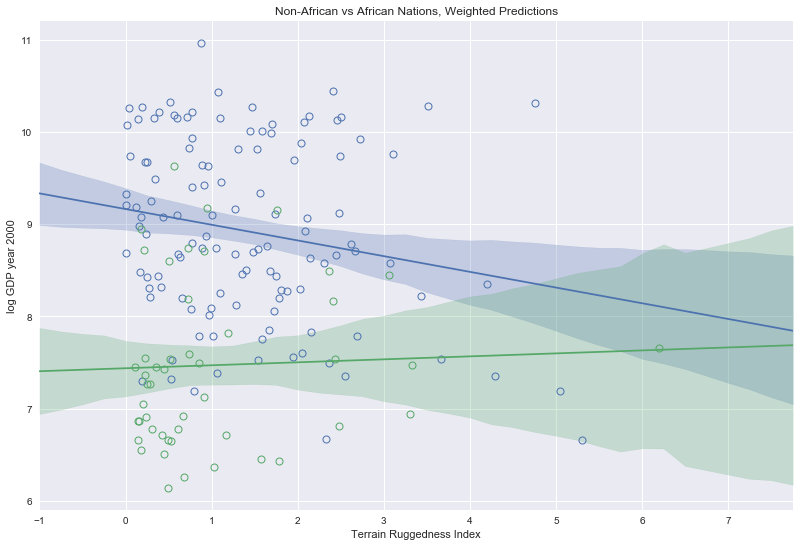

In [58]:
f, ax = plt.subplots(1, 1)
f.set_size_inches(13.5, 9)

ax.plot(rugged_nonch.loc[lambda df: df["cont_africa"] == 0]["rugged"], 
        rugged_nonch.loc[lambda df: df["cont_africa"] == 0]["log_rgdppc_2000"], 
        "o", mew=1, mec="C0", mfc="None")
ax.plot(rugged_nonch.loc[lambda df: df["cont_africa"] == 1]["rugged"], 
        rugged_nonch.loc[lambda df: df["cont_africa"] == 1]["log_rgdppc_2000"], 
        "o", mew=1, mec="C1", mfc="None")
ax.plot(rugged_seq, wmu_na_mean, color="C0")
ax.plot(rugged_seq, wmu_wa_mean, color="C1")
ax.fill_between(rugged_seq, wmu_na_pi[:,0], wmu_na_pi[:,1], alpha=0.25, color="C0")
ax.fill_between(rugged_seq, wmu_wa_pi[:,0], wmu_wa_pi[:,1], alpha=0.25, color="C1")
ax.set_title("Non-African vs African Nations, Weighted Predictions")
ax.set_xlabel("Terrain Ruggedness Index")
ax.set_xlim((-1, 7.75))
ax.set_ylabel("log GDP year 2000");

My inferences haven't changed since the model with the interaction has the highest weight (80%), this implies that the slope of ruggedness to log GDP does depend on continent.

#### 7H4.

In [59]:
d = pd.read_csv("data/nettle.csv", sep=";")

### 7.34

In [60]:
d["lang.per.cap"] = d["num.lang"]/d["k.pop"]

##### (a)

In [61]:
d["mean.growing.season_s"] = (d["mean.growing.season"] - d["mean.growing.season"].mean())/d["mean.growing.season"].std()
d["log_area"] = np.log(d["area"])
d["log_area_s"] = (d["log_area"] - d["log_area"].mean())/d["log_area"].std()

In [62]:
with pm.Model() as m7h_8:
    sigma = pm.Uniform("sigma", 0, 10)
    bM = pm.Normal("bM", mu=0, sd=1)
    bA = pm.Normal("bA", mu=0, sd=1)
    a = pm.Normal("a", mu=0, sd=100)
    mu = pm.Deterministic("mu", a +\
                                bM*d["mean.growing.season_s"] +\
                                bA*d["log_area_s"])
    log_lang_per_cap = pm.Normal("log_lang_per_cap", mu=mu, sd=sigma, 
                                 observed=np.log(d["lang.per.cap"]))
    trace7h_8 = pm.sample(draws=1000, tune=1000)

Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (2 chains in 2 jobs)
NUTS: [a, bA, bM, sigma]
Sampling 2 chains: 100%|██████████| 4000/4000 [00:03<00:00, 1193.04draws/s]


In [63]:
pm.summary(trace7h_8, varnames=["a", "bM", "bA", "sigma"], alpha=0.11)

,mean,sd,mc_error,hpd_5.5,hpd_94.5,n_eff,Rhat
a,-5.455807,0.174250,0.003102,-5.724990,-5.180493,3108.118508,0.999583
bM,0.440825,0.182439,0.004223,0.143589,0.711513,1934.423968,0.999503
bA,-0.258537,0.185454,0.003816,-0.565560,0.020741,1962.979976,0.999540
sigma,1.448175,0.129845,0.002489,1.232914,1.633848,2703.770065,0.999526


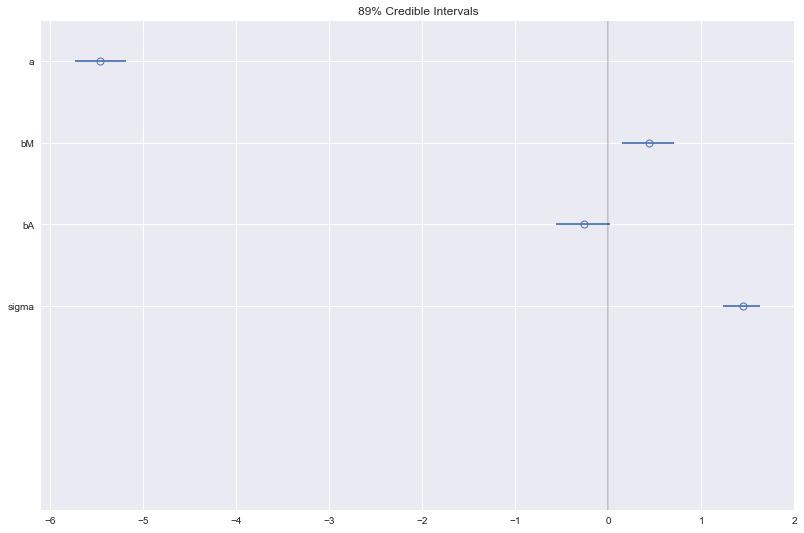

In [64]:
f, ax = plt.subplots(1, 1)
f.set_size_inches(13.5, 9)
data = (pm.summary(trace7h_8, varnames=["a", "bM", "bA", "sigma"], alpha=0.11)
        .assign(hpd_minus=lambda df: df["mean"] - df["hpd_5.5"])
        .assign(hpd_plus=lambda df: df["hpd_94.5"]- df["mean"]))
ax.errorbar(data["mean"], data.index, fmt="o", xerr=data[["hpd_minus", "hpd_plus"]].T.values, 
            mew=1, mfc="None")
ax.vlines(0, ymin=-1, ymax=6, alpha=0.2);
ax.set_ylim(-0.5, 5.5)
ax.invert_yaxis()
ax.set_title("89% Credible Intervals");

The average length of the growing season does seem to have a positive effect on log(lang.per.cap), log(Area) doesn't seem to have an effect in this model.

##### (b)

In [65]:
d["sd.growing.season_s"] = (d["sd.growing.season"] - d["sd.growing.season"].mean())/d["sd.growing.season"].std()

In [66]:
with pm.Model() as m7h_9:
    sigma = pm.Uniform("sigma", 0, 10)
    bS = pm.Normal("bS", mu=0, sd=1)
    bA = pm.Normal("bA", mu=0, sd=1)
    a = pm.Normal("a", mu=0, sd=100)
    mu = pm.Deterministic("mu", a +\
                                bS*d["sd.growing.season_s"] +\
                                bA*d["log_area_s"])
    log_lang_per_cap = pm.Normal("log_lang_per_cap", mu=mu, sd=sigma, 
                                 observed=np.log(d["lang.per.cap"]))
    trace7h_9 = pm.sample(draws=1000, tune=1000)

Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (2 chains in 2 jobs)
NUTS: [a, bA, bS, sigma]
Sampling 2 chains: 100%|██████████| 4000/4000 [00:04<00:00, 886.54draws/s] 


In [67]:
pm.summary(trace7h_9, varnames=["a", "bS", "bA", "sigma"], alpha=0.11)

,mean,sd,mc_error,hpd_5.5,hpd_94.5,n_eff,Rhat
a,-5.451461,0.169972,0.003341,-5.738822,-5.194751,2272.900918,1.000089
bS,-0.216414,0.204740,0.005188,-0.542578,0.104893,1458.058604,1.000048
bA,-0.299781,0.207029,0.005455,-0.641044,0.023715,1203.365881,0.999602
sigma,1.498894,0.131112,0.003043,1.291215,1.699495,1824.062210,0.999644


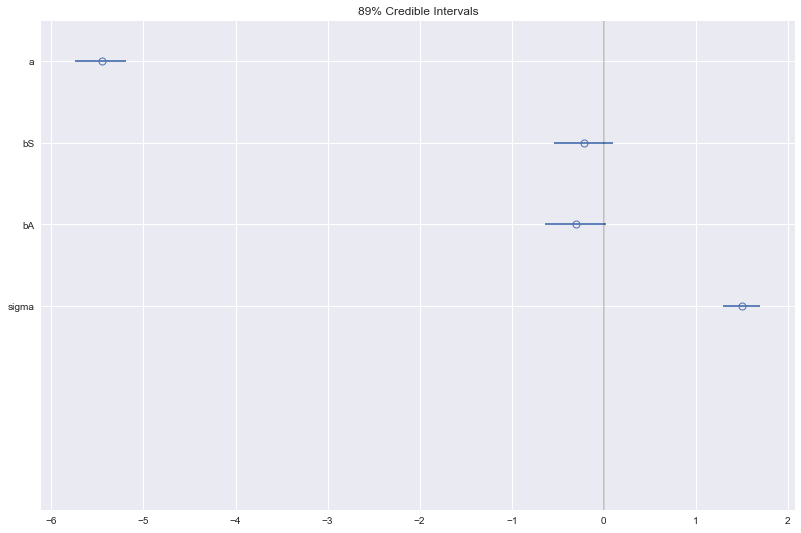

In [68]:
f, ax = plt.subplots(1, 1)
f.set_size_inches(13.5, 9)
data = (pm.summary(trace7h_9, varnames=["a", "bS", "bA", "sigma"], alpha=0.11)
        .assign(hpd_minus=lambda df: df["mean"] - df["hpd_5.5"])
        .assign(hpd_plus=lambda df: df["hpd_94.5"]- df["mean"]))
ax.errorbar(data["mean"], data.index, fmt="o", xerr=data[["hpd_minus", "hpd_plus"]].T.values, 
            mew=1, mfc="None")
ax.vlines(0, ymin=-1, ymax=6, alpha=0.2);
ax.set_ylim(-0.5, 5.5)
ax.invert_yaxis()
ax.set_title("89% Credible Intervals");

The standard deviation of the growing season does not seem to have an effect on log(lang.per.cap), log(Area) doesn't seem to have an effect in this model either.

##### (c)

In [69]:
model_mg_s = theano.shared(d["mean.growing.season_s"].values)
model_sg_s = theano.shared(d["sd.growing.season_s"].values)
model_a_s = theano.shared(d["log_area_s"].values)

In [70]:
with pm.Model() as m7h_10:
    sigma = pm.Uniform("sigma", 0, 10)
    bM = pm.Normal("bM", mu=0, sd=1)
    bS = pm.Normal("bS", mu=0, sd=1)
    bMS = pm.Normal("bMS", mu=0, sd=1)
    bA = pm.Normal("bA", mu=0, sd=1)
    a = pm.Normal("a", mu=0, sd=100)
    mu = pm.Deterministic("mu", a +\
                                bM*model_mg_s +\
                                bS*model_sg_s +\
                                bMS*model_mg_s*model_sg_s +\
                                bA*model_a_s)
    log_lang_per_cap = pm.Normal("log_lang_per_cap", mu=mu, sd=sigma, 
                                 observed=np.log(d["lang.per.cap"]))
    trace7h_10 = pm.sample(draws=1000, tune=1000)

Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (2 chains in 2 jobs)
NUTS: [a, bA, bMS, bS, bM, sigma]
Sampling 2 chains: 100%|██████████| 4000/4000 [00:05<00:00, 758.63draws/s] 


100%|██████████| 10000/10000 [00:01<00:00, 5618.67it/s]


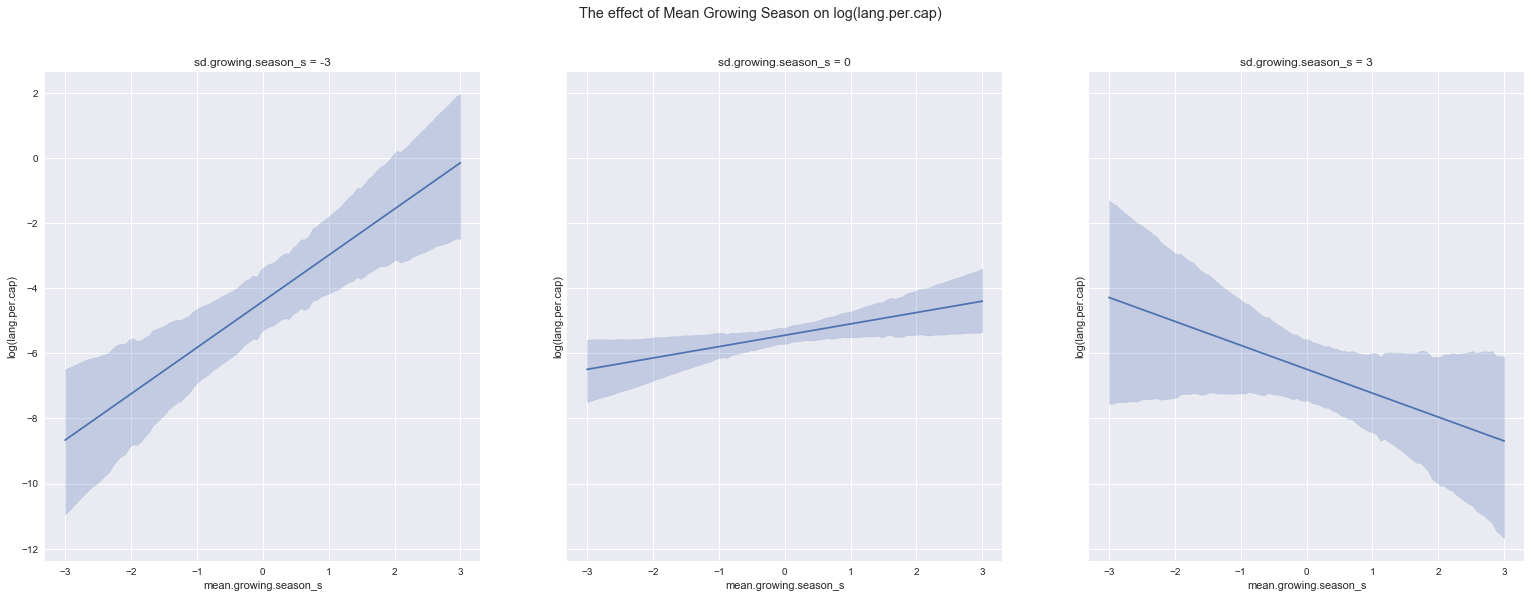

In [71]:
f, axs = plt.subplots(1, 3, sharey=True)
f.set_size_inches(26.5, 9)
f.suptitle("The effect of Mean Growing Season on log(lang.per.cap)")

mg_seq = np.linspace(-3, 3, 100)
model_mg_s.set_value(mg_seq)
model_a_s.set_value(np.repeat(0, 100))

for (sg, ax) in zip([-3, 0, 3], axs):
    model_sg_s.set_value(np.repeat(sg, 100))
    mu = pm.sample_ppc(trace7h_10, samples=10000, model=m7h_10, vars=[m7h_10.mu])["mu"]
    mu_mean = mu.mean(0)
    mu_pi = pm.hpd(mu, alpha=0.11)
    ax.plot(mg_seq, mu_mean, color="C0")
    ax.fill_between(mg_seq, mu_pi[:,0], mu_pi[:,1], alpha=0.25, color="C0")
    ax.set_title("sd.growing.season_s = {}".format(sg))
    ax.set_xlabel("mean.growing.season_s")
    ax.set_ylabel("log(lang.per.cap)");

It does look like there's a strong interaction effect between mean.growing.season and sd.growing.season with the effect reversing diretion at differet values of sd.growing.season